In [1]:
from scipy import signal
from scipy.stats import norm
import numpy as np
from skimage.restoration import denoise_wavelet

def preprocess_vibration_data(data, sampling_frequency, lpf):
    # Step 1: Band-pass filtering
    # Design a Butterworth band-pass filter from 0.1 Hz to the Nyquist frequency
    b, a = signal.butter(4, lpf / (sampling_frequency / 2))
    
    # Apply the filter to the data
    data_filtered = signal.lfilter(b, a, data)
    

    # Step 3: Signal conditioning
    # Subtract the mean and divide by the standard deviation
    conditioned_data = (data_filtered - np.mean(data_filtered)) / np.std(data_filtered)
    rms= np.sqrt(np.mean(np.square(conditioned_data)))
    return conditioned_data, rms

In [2]:


def apply_welch(sig, sr:int,nperseg:int,noverlap:int|None=None):
    if noverlap is None:
        noverlap = nperseg // 2
    f, Pxx_den = signal.welch(sig, sr, nperseg=nperseg, noverlap=noverlap)
    return f, Pxx_den


In [52]:
from scipy.signal import find_peaks
def introduce_anomaly(Pxx_den, f, freq_OI=30, shift=0.1):
    # Identifying the peaks

    
    Pxx = np.log10(Pxx_den)
    peak_indices = find_peaks(Pxx, prominence=0.05)[0]
    peaks_freqs = f[peak_indices]
    print(peaks_freqs)
    peak_powers = Pxx[peak_indices]

    # Finding the peak of interest
    modal_OI = np.argmin(np.abs(peaks_freqs - freq_OI))
    peak_power_OI = peak_powers[modal_OI]
    print(f[modal_OI])



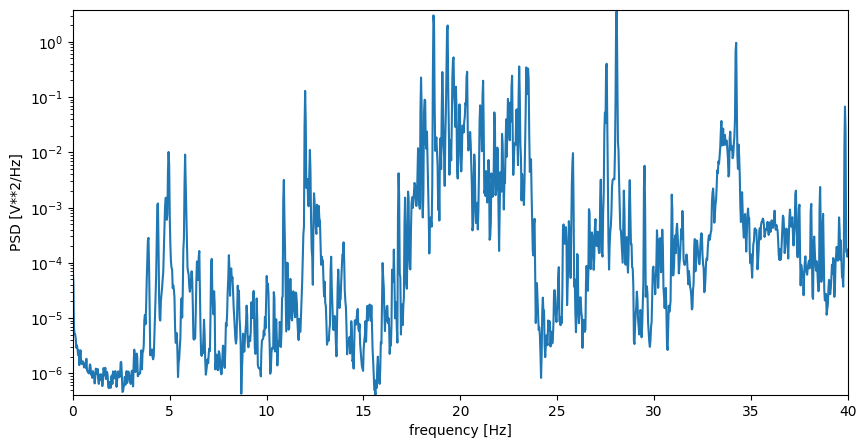

In [68]:
import sys
from pathlib import Path
from datetime import datetime, timedelta
import logging
import h5py
from VOOD.data import data_loader as dl
from config import settings
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, Manager
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh
from scipy.signal import find_peaks


EPS = sys.float_info.epsilon
psd_frame = timedelta(minutes=10)
start_time = datetime(2022, 3, 30, 0, 0, 0)
end_time = datetime(2022, 6, 25, 0, 0, 0)
dt = datetime(2022, 4, 21, 0, 0, 0)
psd_frame = timedelta(minutes=5)
psd_step = timedelta(minutes=8)
sensor = dl.Sensor(name='ACC', location='MO04', data_type='TDD', format='.tdms')
loader = dl.DataLoader(sensor=sensor)
data = loader.get_data(dt, dt + psd_frame)
time = np.arange(0, len(data['ACC3_Z'])) / 250

sig = data['ACC3_Z']
filtered_data, time = preprocess_vibration_data(sig, 250,50)
f, Pxx_den = apply_welch(filtered_data, 250, 8192)
fig,ax=plt.subplots(figsize=(10, 5))
ax.plot(f, Pxx_den)
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
ax.set_xlim([0, 40])
ax.set_ylim(Pxx_den[0:int(40/(200/8192))].min(), Pxx_den[0:int(40/(200/8192))].max())
ax.set_yscale('log')


In [54]:
from scipy.signal import find_peaks
def introduce_anomaly(Pxx_den, f, freq_OI=30, shift=0.1):
    # Identifying the peaks

    
    Pxx = np.log10(Pxx_den)
    peak_indices = find_peaks(Pxx, prominence=0.05)[0]
    peaks_freqs = f[peak_indices]
    print(peaks_freqs)
    peak_powers = Pxx[peak_indices]

    # Finding the peak of interest
    modal_OI = np.argmin(np.abs(peaks_freqs - freq_OI))
    peak_power_OI = peak_powers[modal_OI]
    print(f[modal_OI])



In [82]:
shift = 1

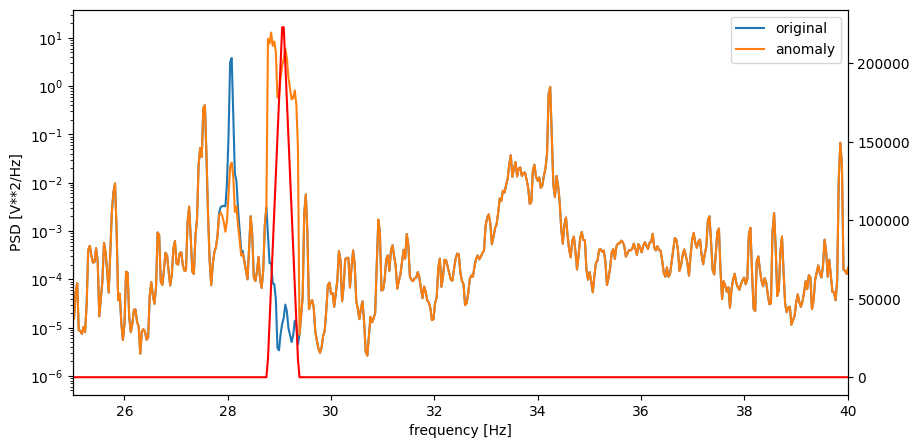

In [110]:
from scipy.signal.windows import triang
Pxx_log = Pxx_den

# Find peaks in the PSD
peak_indices = find_peaks(Pxx_log, prominence=0.0001)[0]
peaks_freqs = f[peak_indices]

# Find the mode of interest
modal_OI = np.argmin(np.abs(peaks_freqs - 28))
peak_power_OI = Pxx_log[peak_indices[modal_OI]]

# Define a new mode
new_mode = f[peak_indices[modal_OI]] + shift
arg_new_mode = np.argmin(np.abs(f - new_mode))

# Corresponding argument in frequency array
index_MOI = np.argmin(np.abs(Pxx_den - peaks_freqs[modal_OI]))

# Copy the original PSD and modify to simulate anomaly
Pxx_den_a = Pxx_den.copy()
window = np.ones_like(Pxx_den_a)
window[index_MOI-10:index_MOI+10]*= 1-np.hanning(20) * peak_power_OI/Pxx_den[index_MOI]
window[arg_new_mode-10:arg_new_mode+10]*= triang(20)*peak_power_OI/Pxx_den[arg_new_mode]
Pxx_den_a *= window

fig,ax=plt.subplots(figsize=(10, 5))
ax.plot(f, Pxx_den, label='original')
ax.plot(f, Pxx_den_a, label='anomaly')
ax1 = ax.twinx()
ax1.plot(f, window, color='red', label='window')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
ax.set_xlim([25, 40])
ax.set_ylim(Pxx_den[0:int(40/(200/8192))].min(), Pxx_den[0:int(40/(200/8192))].max()*10)
ax.set_yscale('log')
ax.legend()

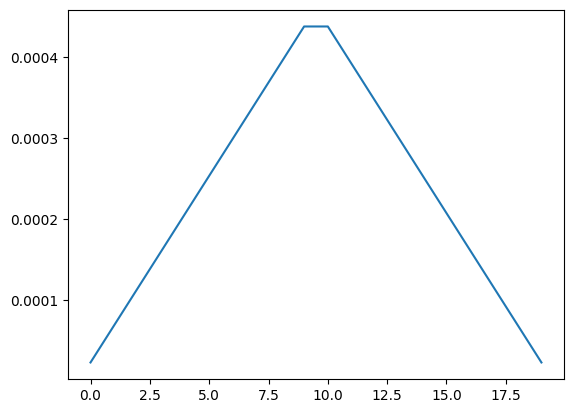

In [101]:
plt.plot(triang(20)*Pxx_den[index_MOI-10])